**рекуррентная нейронная сеть Элмана**

Евгений Борисов <esborisov@sevsu.ru>


построим простую языковая модель и
обучим её предсказывать последнюю букву в слове


----

Евгений Борисов  О рекуррентных нейронных сетях.    
http://mechanoid.su/neural-net-rnn.html

Jeffrey L. Elman Finding Structure in Time // COGNITIVE SCIENCE 14, 179-211 (1990)

---

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# загружаем тексты

In [2]:
# загружаем тексты
import gzip
import requests
from bs4 import BeautifulSoup

In [3]:
url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
text = BeautifulSoup(requests.get(url).text).get_text()
with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:355])

символов:1279540
---------------

Приступая к описанию недавних и столь странных событий, происшедших в нашем, доселе ничем не отличавшемся городе, я принужден, по неумению моему, начать несколько издалека, а именно некоторыми биографическими подробностями о талантливом и многочтимом Степане Трофимовиче Верховенском. Пусть эти подробности послужат лишь введением к предлагаемой хронике, 


----

In [4]:
data_size = 1024
offset = rng.randint( len(text) - data_size )
text_ = text[offset:offset+data_size]
print(text_)

 Шатов знает?
   Волнение было неописанное.
   - Всё совершенно верно. Я не вправе вам объявить пути мои и как открывал, но вот что покамест я могу для вас сделать: чрез одно лицо я могу подействовать на Шатова, так что он, совершенно не подозревая, задержит донос, -- на не более как на сутки. Дальше суток не могу. Итак, вы можете считать себя обеспеченными до послезавтраго утра.
   Все молчали.
   - Да отправить же его наконец к черту! - первый крикнул Толкаченко.
   - И давно бы надо сделать! - злобно ввернул Лямшин, стукнув кулаком по столу.
   - Но как сделать? - пробормотал Липутин.
   Петр Степанович тотчас же подхватил вопрос и изложил свой план. Он состоял в том, чтобы завлечь Шатова, для сдачи находившейся у него тайной типографии, в то уединенное место, где она закопана, завтра, в начале ночи, и - "уж там и распорядиться". Он вошел во многие нужные подробности, которые мы теперь опускаем, и разъяснил обстоятельно те настоящие двусмысленные отношения Шатова к центральному обще

# собираем генератор дататасета

In [5]:
class SeqDataset:
    
    def __init__(self,text,contex_len,w_step=1):
        assert len(text)>1

        abc = sorted(set(text))
        self._vocabulary = { c:n for n,c in enumerate(abc) }
        self._data = np.array([
                self._encode(text[n:n+contex_len+1]) 
                for n in range(0,len(text)-(contex_len+1),w_step) 
            ],dtype=int)
        
    @property
    def vocabulary(self): 
        return self._vocabulary
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( 
            self._one_hot( self._data[idx,:-1] ),  
            self._one_hot( self._data[idx,-1] ) 
        )
    
    # заменить в последовательности все токены на их номера в словаре
    def _encode(self,w):
        return [ self._vocabulary[c] for c in w if (c in self._vocabulary) ]
        
    # размер датасета
    def __len__(self): 
        return len(self._data)   
    
    def _one_hot(self,x):
        return np.eye(len(self._vocabulary))[x]

In [6]:
ds = SeqDataset(text_,24,w_step=16)
display(len(ds) )
display(len(ds.vocabulary))
# display(ds.words)

63

52

In [7]:
# x= np.array([1,2,0,3])
# np.eye(4)[x]

---

In [8]:
x,t = ds[:2]
display((x.shape,t.shape))

((2, 24, 52), (2, 52))

In [9]:
# ds.vocabulary

In [10]:
# t

In [11]:
class DataLoader:
    
    def __init__(self,dataset,batch_size,shuffle=True):    
        self._ds = dataset
        n_samples = len(dataset) # количество учебных пар
        # перемешиваем учебный набор 
        indices = rng.permutation(n_samples) if shuffle else np.arange(n_samples)
        batch_count = np.ceil( n_samples/batch_size).astype(int) # количество батчей
        self._indices = np.array_split(indices,batch_count ) # режем на батчи

    # генератор батчей
    def __iter__(self):
        # перемешиваем учебный набор и режем его на батчи
        for idx in self._indices :
            yield self._ds[idx]

In [12]:
for x,t in DataLoader(ds,16): break
display((x.shape,t.shape))

((16, 24, 52), (16, 52))

# строим модель

## функция активации

In [13]:
class Activation:
    
    def forward(self,x): pass

    def backward(self,x): pass # производная активации
    
    def __call__(self,x):
        return self.forward(x)    

In [14]:
class BiSigmoid(Activation):
    
    def forward(self,x): 
        return np.tanh(x)

    def backward(self,x): # производная активации
        return 1./(np.cosh(x)**2)

Text(0.5, 1.0, 'd bi_sigmoid')

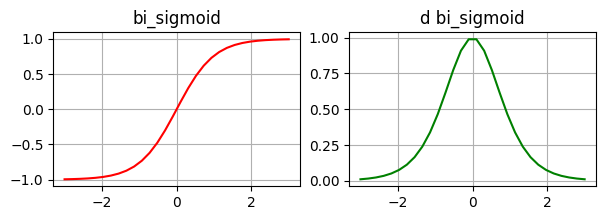

In [15]:
f = BiSigmoid()
x = np.linspace(-3,3,30)
fig,ax = plt.subplots(ncols=2,figsize=(7,2))
ax[0].plot(x,f(x),'-r')
ax[0].grid()
ax[0].set_title('bi_sigmoid' )
ax[1].plot(x,f.backward(x),'-g')
ax[1].grid()
ax[1].set_title('d bi_sigmoid' )

$$
sigmoid(x) = \frac{1}{1+\exp(-x)}
$$

In [16]:
class Sigmoid(Activation): # функция активации
    
    def forward(self,x): 
        return 1./(1. + np.exp(-x))

    def backward(self,x): # производная активации
        return np.square(self.forward(x))*np.exp(-x) 

Text(0.5, 1.0, 'd sigmoid')

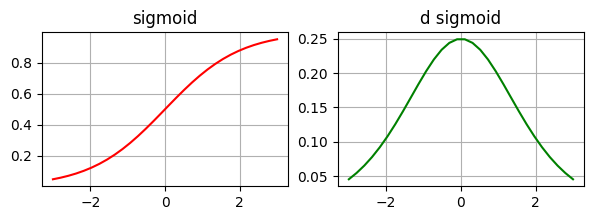

In [17]:
f = Sigmoid()
x = np.linspace(-3,3,30)
fig,ax = plt.subplots(ncols=2,figsize=(7,2))
ax[0].plot(x,f(x),'-r')
ax[0].grid()
ax[0].set_title('sigmoid' )
ax[1].plot(x,f.backward(x),'-g')
ax[1].grid()
ax[1].set_title('d sigmoid' )

$$
softmax(x) = \frac{\exp(x)}{\sum{\exp(x)}}
$$

In [18]:
class Softmax(Activation):
    
    def forward(self,x): 
        e = np.exp(x)
        d = e.sum(axis=-1,keepdims=True)
        with np.errstate(divide='ignore',invalid='ignore'):
            r = np.where(d>1e-6,(e/d), e )
        return r

    def backward(self,x): 
        o = self.forward(x)
        return o*(1.-o)

## слой сети 

In [19]:
class Model:
    
    def forward(self,x): pass

    def forward_train(self,x): pass
    
    def backward(self,d): pass
    
    def gradient(self,x,d): pass
    
    def __call__(self,x):
        return self.forward(x)
        
    def predict(self,x):
        return np.argmax(self.forward(x),axis=-1,keepdims=True)
    
    @property
    def weight(self): pass

    @weight.setter
    def weight(self,w): pass

## линейный слой

схема нейрона

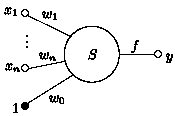

In [20]:
class Linear(Model):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self._weight = rng.normal(loc=0.,scale=1e-1,size=(in_size,out_size))
        self._bias = np.zeros(shape=(1,out_size))
        
    def forward(self,x):
        assert len(x)>0
        assert x.shape[-1]==self._weight.shape[0]
        return x.dot(self._weight)+self._bias

    def forward_train(self,x):
        return self.forward(x)
    
    def backward(self,d):
        return d.dot(self._weight.T)
    
    def gradient(self,x,d):
        return x.T.dot(d), d.sum(axis=0,keepdims=True) 
    
    @property
    def weight(self):
        return self._weight, self._bias

    @weight.setter
    def weight(self,w):
        self._weight=w[0] 
        self._bias=w[1]
        return self

In [21]:
# display((x_train.shape,y_train.shape))

# model = Linear(in_size=x_train.shape[1],out_size=y_train.shape[1])

# o = model(x_train)
# display(o.shape)

# o = model.forward_train(x_train)
# display(o.shape)

# d = model.backward(y_train-o)
# display(d.shape)

# dw,db = model.gradient(x_train,d)
# display((dw.shape,db.shape))

## рекуррентный слой

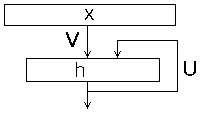

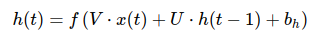

In [22]:
class RNN(Model):
    
    def __init__(self,in_size,hidden_size):
        super().__init__()
        self._weight_in = rng.normal(loc=0.,scale=1e-5,size=(in_size,hidden_size))
        self._weight_hidden = rng.normal(loc=0.,scale=1e-5,size=(hidden_size,hidden_size))
        self._bias = np.zeros(shape=(1,hidden_size))
        self._hidden = np.zeros(shape=(1,hidden_size)) # np.array(0.)
        self._activation = BiSigmoid()
        
    def forward(self,x,h=None):
        assert len(x)>0
        assert x.shape[-1]==self._weight_in.shape[0]

        batch_size, seq_len, emb_size = x.shape
        _,hidden_size = self._hidden.shape
        
        self._hidden = h if not (h is None) else np.zeros(shape=(1,hidden_size))
        for i in range(seq_len): 
            o = self._activation(self._forward_step(x[:,i,:]))
        return self._hidden, o
    
    def _forward_step(self,x):
        assert len(x)>0
        assert x.shape[-1]==self._weight_in.shape[0]
        self._hidden = x.dot(self._weight_in) + self._hidden.dot(self._weight_hidden) + self._bias
        return self._hidden
        
    def forward_train(self,x,h=None):
        assert len(x)>0
        assert x.shape[-1]==self._weight_in.shape[0]
        n_samples, seq_len, _ = x.shape
        hidden,out = [],[]
        
        _,hidden_size = self._hidden.shape
        self._hidden = h if not (h is None) else np.zeros(shape=(1,hidden_size))
        for i in range(seq_len): 
            hidden.append( self._forward_step(x[:,i,:]) )
            out.append( self._activation( hidden[-1] ) )
        return hidden, out
    
    def backward(self,d,state):
        seq_len = len(state)
        delta_h = [d]
        delta_i = []
        for s in state[::-1]:
            delta_h.append( delta_h[-1].dot(self._weight_hidden.T)*self._activation.backward(s) )
            delta_i.append( delta_h[-1].dot(self._weight_in.T) )
        return delta_h[:-1][::-1],delta_i[::-1]
    
    def gradient(self,x,out,delta):
        batch_size,seq_len,_ = x.shape
        dw,dwr,db = 0.,0.,0.
        for i in range(seq_len):
            dw  += x[:,i,:].T.dot( delta[i] )
            dwr += out[i].T.dot( delta[i] )
            db  += delta[i].sum(axis=0,keepdims=True) 
        return dw,dwr,db
    
    @property
    def weight(self):
        return self._weight_in, self._weight_hidden,  self._bias

    @weight.setter
    def weight(self,w):
        self._weight_in=w[0] 
        self._weight_hidden=w[1] 
        self._bias=w[2]
        return self
    
    @property
    def hidden(self):
        return self._hidden

In [23]:
# x = rng.rand(2,3,4)
# display(x.shape)

# model = RNN(4,5)
# h,o = model(x)
# display( ( np.stack(h).shape,np.stack(o).shape ) )

# h,o = model.forward_train(x)
# display( ( np.stack(h).shape,np.stack(o).shape ) )

# d_h,d_i = model.backward(o[-1],h)
# display( ( np.stack(d_h).shape,np.stack(d_i).shape ) )

# dw,dwr,db = model.gradient(x,o,d_h)
# display((dw.shape,dwr.shape,db.shape))

# рекуррентная сеть Элмана

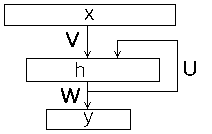

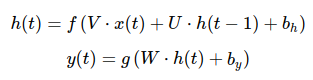

In [24]:
class ElmanRNN(Model):
    
    def __init__(self,vocabulary_size,emb_size,hidden_size):
        super().__init__()
        self._rnn = RNN(vocabulary_size,hidden_size)
        self._lin = Linear(hidden_size,vocabulary_size)
        self._activation = Softmax()
                
    @property
    def weight(self):
        return self._rnn.weight, self._lin.weight

    @weight.setter
    def weight(self,w):
        self._rnn.weight=w[0] 
        self._lin.weight=w[1]
        return self
    
    def forward(self,x):
        assert len(x)>0
        _,o = self._rnn(x)
        o = self._lin(o)
        o = self._activation(o)
        return o
     
    def forward_train(self,x):
        state,out = [x],[]
        
        h,o = self._rnn.forward_train(x)
        state.append(h)
        out.append(o)
        
        s = self._lin.forward_train(o[-1])
        o = self._activation(s)
        state.append(s)
        out.append(o)
        
        return state, out
    
    def backward(self,d,state):
        delta = [ d*self._activation.backward(state[2]) ]
        delta.append( self._lin.backward( delta[-1] ) * self._activation.backward( state[1][-1]) )
        delta.extend( self._rnn.backward( delta[-1], state[1] ) )
        return delta[::-1] 
    
    def gradient(self,x,out,delta):
        dw0,dw0r,db0 = self._rnn.gradient(x,out[0],delta[1])
        dw1,db1 = self._lin.gradient(out[0][-1],delta[3])
        return [dw0,dw0r,db0],[dw1,db1] 


In [25]:
# x,t = ds[:2]
# display( (x.shape,t.shape) )

# model = ElmanRNN(vocabulary_size=len(ds.vocabulary),emb_size=32,hidden_size=16)

# # o = model.forward(x)
# # display(o.shape)

# s,o = model.forward_train(x)
# display( ( len(s),len(o) ) )

# # s[0].shape # == x : batch_size, seq_len, vocabulary_size
# #np.stack(s[1]).shape #  seq_len, batch_size, hidden_size
# #s[2].shape #  batch_size, vocabulary_size

# #np.stack(o[0]).shape # seq_len, batch_size, hidden_size
# #o[1].shape #  batch_size, vocabulary_size

In [26]:
# er = o[1][-1]-t
# display(er.shape) #  batch_size, vocabulary_size

# d = model.backward(er,s)
# display(len(d) )

# # d[3].shape # to lin : batch_size, vocabulary_size 
# # d[2].shape #  to rnn hidden0: batch_size, hidden_size
# # np.stack(d[1]).shape # to rnn hidden: seq_len, batch_size, hidden_size
# # np.stack(d[0]).shape # to emb : seq_len, batch_size, emb_size

In [27]:
# # g = model.gradient(x,o,d)

# [dw1,dw1r,db1],[dw2,db2] = model.gradient(x,o,d)
# display((dw1.shape, dw1r.shape, db1.shape))
# display((dw2.shape, db2.shape))

# обучаем модель

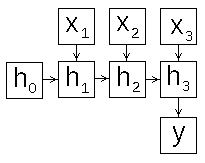

градиент функции потери - частные производные по всем параметрам модели, направление наискорейшего возрастания функции 

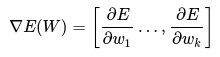


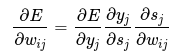

процедура обратного распространения ошибки

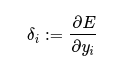

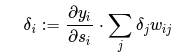

In [28]:
class Loss:
    
    def __init__(self,model): 
        self._model = model
        self._history = []
                
    def estimate(self,x,target):
        s = self._estimate( predicted=self._model(x), target=target, )
        self._history.append(s)
        return s
        
    def _estimate(self,predicted,target): pass
    
    def gradient(self,x,target):
        s,o = model.forward_train(x) # состояния и выходы всех нейронов сети
        d0 = self._gradient(o=o[-1],target=target) # ошибка выходного слоя
        d = model.backward(d0,s) # значение ошибки для всех нейронов скрытых слоёв
        return model.gradient(x,o,d) 
    
    def _gradient(self,o,target): pass
    
    def __call__(self,x,target):
        return self.estimate(x,target)        
    
    @property
    def model(self): 
        return self._model

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [29]:
# class MSQELoss(Loss):
    
#     def _estimate(self,predicted,target):
#         return np.square(target-predicted).mean()
    
#     def _gradient(self,o,target):
#         return (o-target) # ошибка выходного слоя

функция потери - кросс-энтропия

$$L = CE(y,o) = -y\cdot log(o) - (1-y) \cdot log(1-o)  $$

$$  \nabla L = \frac{\partial L}{\partial w} = -\frac{o-y }{o (o-1)}\cdot \frac{\partial o}{\partial w}$$ 

In [30]:
class CELoss(Loss):
    
    def _estimate(self,predicted,target):
        o,y=predicted,target
        with np.errstate(divide='ignore',invalid='ignore'):
            # доопределяем нулями логарифм для аргументов меньше или равно 0
            l0 = np.where( o<1., (1-y)*np.log(1.-o), 0. )
            l1 = np.where( o>0., y*np.log(o),        0. ) 
        return -(l1+l0).sum()/len(y)    
    
    def _gradient(self,o,target):
        d = o*(o-1)
        with np.errstate(divide='ignore',invalid='ignore'):
            d = np.where(d!=0.,(1./d), .0 )
        return -(o-target)*d # ошибка выходного слоя

---

In [31]:
# x,t = ds[:2]
# display( (x.shape,t.shape) )

# model = ElmanRNN(in_size=x.shape[-1],hidden_size=16,out_size=x.shape[-1])

# o = model.forward(x)
# display(o.shape)

# loss = CELoss(model)
# #loss = MSQELoss(model)
# er = loss.estimate(x,t)
# display( er  )

# [dw0,dw0r,db0],[dw1,db1] = loss.gradient(x,t)
# display((dw0.shape,dw0r.shape,db0.shape),(dw1.shape,db1.shape),)

---

In [32]:
from copy import deepcopy

class Weight:
    
    def __init__(self,w):
        self._w = deepcopy(w)
    
    def __add__(self,w):
        return self._for_all(w,operation=lambda x,y:x+y)
        
    def __sub__(self,w):
        return self._for_all(w,operation=lambda x,y:x-y)
    
    def __mul__(self,w):  
        return self._for_all(w,operation=lambda x,y:x*y)
        
    def fill(self,w):
        return self._for_all(w,operation=lambda x,y: w )
        
    def _for_all(self,w,operation):  
        return Weight([ 
                [ 
                 operation( self._w[l][n], self._get_value(w,l,n) ) 
                 for n in range(len( self._w[l])) 
                ] # для каждого параметра слоя
                for l in range(len( self._w)) # для каждого слоя
            ])  
    
    def max(self):  
        return max([ 
                max([ np.abs(self._w[l][n]).max() 
                     for n in range(len( self._w[l])) 
                    ]) # для каждого параметра слоя
                for l in range(len( self._w)) # для каждого слоя
            ])
    
    def norm(self):
        m = self.max()
        return self.__mul__(1./m) if m>0. else Weight(self._w)
    
    def _get_value(self,w,l,n):
        return w[l,n] if type(w) is Weight else w
        
    def __getitem__(self,idx): 
        return self._w[idx[0]][idx[1]]
    
    @property
    def value(self): return self._w

# обучаем

In [33]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

изменение весов

$$\Delta w_t = \eta \cdot ( \nabla L + \rho\cdot W_{t-1} ) + \mu\cdot \Delta w_{t-1}$$

In [34]:
class TrainSGD:
    
    def __init__(self,loss,lr=1e-2,mu=0.,rho=0.): 
        self._loss = loss
        self._lr = lr # скорость обучения
        self._dw = 0. # изменение весов на предыдущем шаге
        self._mu = mu # коэфициент момента
        self._rho = rho # коэфициент регуляризации
        self._bs = 1.
        
    def fit(self,data_loader,n_epoch=128,acc_min=.97):
        loss_history = []
        acc_history = []
        for _ in tqdm(range(n_epoch)):
            loss_history_batch = []
            acc_history_batch = []
            self._dw = Weight(self._loss.model.weight).fill(0.).value
            for x,t in data_loader:
                self._fit_epoch(x,t)
                loss_history_batch.append( self._loss.estimate(x,t) )
                acc_history_batch.append( accuracy_score(np.argmax(t,axis=-1),self._loss.model.predict(x)) )
            loss_history.append( np.mean(loss_history_batch) )
            acc_history.append( np.mean(acc_history_batch) )
            if acc_history[-1]>acc_min: break
        return (acc_history,loss_history),model 
    
    def _fit_epoch(self,x,t):
        dw = self._loss.gradient(x,t)
        dw = Weight(dw).norm().value
        self._weight_adjust(dw)  
        return self
        
    def _weight_adjust(self,dw):
        dw = Weight( self._weight_delta(dw) )
        w = Weight( self._loss.model.weight ) 
        self._loss.model.weight = (w-dw).value
        return self
        
    
    def _weight_delta(self,dw): # вычисляем изменение всех весов модели
        w = Weight(self._loss.model.weight)
        self._dw = ( 
                ( Weight(dw)+w*self._rho )*self._lr 
                + Weight(self._dw)*self._mu 
            ).value    
        return self._dw        

In [35]:
# rng.seed(343)

In [36]:
model = ElmanRNN(vocabulary_size=len(ds.vocabulary),emb_size=8,hidden_size=512)

  0%|          | 0/3072 [00:00<?, ?it/s]

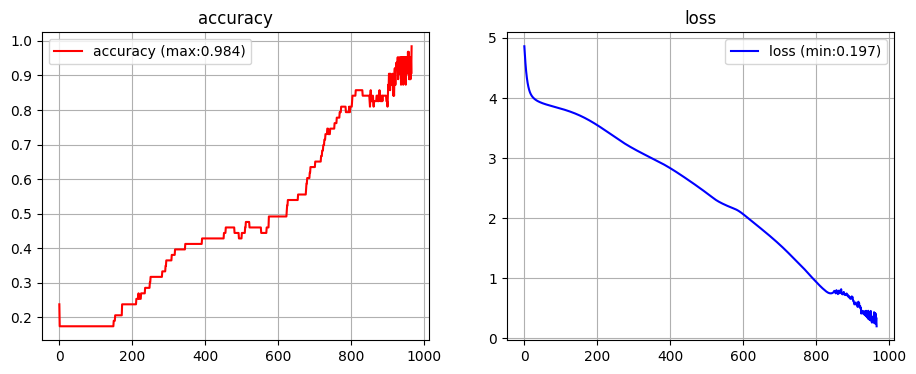

In [37]:
(acc_history,loss_history), model = TrainSGD(
        loss=CELoss(model), lr=1e-1, mu=1e-5, rho=1e-5,
    ).fit( DataLoader(ds,len(ds)//2), n_epoch=1024)

# история изменения значений погрешности модели
fig,ax = plt.subplots(ncols=2,figsize=(11,4))
ax[0].plot(acc_history,label=f'accuracy (max:{max(acc_history):.3f})',c='r' )
ax[0].grid()
ax[0].set_title('accuracy')
ax[0].legend()
ax[1].plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
ax[1].grid()
ax[1].set_title('loss')
ax[1].legend()

# тестируем

In [38]:
from sklearn.metrics import accuracy_score

for x,t in DataLoader(ds,len(ds)): break
p = model.predict(x)
t_ = np.argmax(t,axis=-1,keepdims=True) 
display( accuracy_score(y_true=t_, y_pred=p ) )

0.937

In [39]:
import pandas as pd

In [40]:
def decode(x,vocabulary):
    v = { n:w for w,n in  vocabulary.items() }
    return [ ''.join([ v[c] for c in s ]) for s in x ]

In [41]:
import pandas as pd

for x,t in DataLoader(ds,10): break

p = model.predict(x)
t_ = np.argmax(t,axis=-1,keepdims=True) 
x_ = np.argmax(x,axis=-1) 

# декодируем слова
df = pd.DataFrame({
         'sequence': decode(x_,ds.vocabulary),
           'target': decode(t_,ds.vocabulary),
         'predicted': decode(p,ds.vocabulary)
    })

display(df)

,sequence,target,predicted
0,"есто, где она закопана,",з,з
1,оящие двусмысленные отно,ш,ш
2,ве вам объявить пути мои,,
3,"дозревая, задержит донос",",",","
4,- Да отправить же его,н,н
5,това к центральному обще,с,с
6,"копана, завтра, в начале",,
7,"еперь опускаем, и разъяс",н,н
8,"то уединенное место, гд",е,е
